# PBMC data b4 batch correction
## Xiaonan Wang
## 03Aug2017

In [1]:
%config InlineBackend.figure_formats = ['retina']  # increase resolution on retina screens
%matplotlib inline
import numpy as np
import matplotlib.pyplot as pl
import scanpy.api as sc
from matplotlib.colors import LinearSegmentedColormap
import sys
sys.path.append('/servers/lila-single-cell/Xiaonan/python_modules/')
from TenX_sub import *

sc.settings.verbosity = 0                # increase for more output
sc.settings.set_dpi(80)                  # low pixel number yields small inline figures
sc.logging.print_version_and_date()

/home/USSR/xw251/anaconda2/envs/mypython3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Running Scanpy version 0.2.3 on 2017-11-30 14:41.


## PBMC data read in

In [2]:
%%time
PBMC_data = sc.read("PBMC_cnt.txt", cache=True, delimiter="\t")

CPU times: user 0 ns, sys: 4.47 s, total: 4.47 s
Wall time: 5.78 s


In [3]:
PBMC_data.var_names = np.genfromtxt("genes.tsv", dtype=str)[:, 1]
PBMC_data.var['Ensembl'] = np.genfromtxt("genes.tsv", dtype=str)[:, 0]
PBMC_data.smp_names = np.genfromtxt("PBMC_colnames.txt", dtype=str)
print(PBMC_data.smp_names[0:5])
print(PBMC_data.var_names[0:5])

['A4_AAACCTGAGAGTGACC-1' 'A4_AAACCTGAGCCACGTC-1' 'A4_AAACCTGAGCGTAATA-1'
 'A4_AAACCTGCAAATCCGT-1' 'A4_AAACCTGGTAGCGTCC-1']
['MIR1302-10' 'FAM138A' 'OR4F5' 'RP11-34P13.7' 'RP11-34P13.8']


In [4]:
key_labels_PBMC = np.genfromtxt('PBMC_key_labels.txt', delimiter='\t', dtype=str)
for k in sorted(np.unique(key_labels_PBMC)):
    print(k)
    new_k = [k if x==k else 'others' for x in key_labels_PBMC]
    PBMC_data.smp['s'+k] = new_k
PBMC_data.smp['key_labels'] = key_labels_PBMC

A1
A4
B4


### Remove cells with high doublet score

In [6]:
doublet_score = np.genfromtxt('PBMC_doublet_score.txt', delimiter='\t')
PBMC_data.smp['doublet_score'] = doublet_score

In [7]:
doublet_percentage = 0.75
vline = np.percentile(PBMC_data.smp['doublet_score'], 92.5)
vline_idx = PBMC_data.smp['doublet_score']<vline
print(sum(vline_idx))

15618


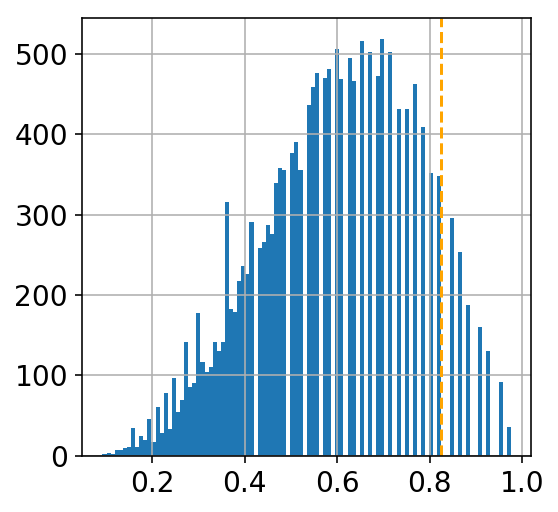

In [8]:
pl.hist(PBMC_data.smp['doublet_score'], 100)
pl.axvline(x=vline, color='orange', linestyle='--')

In [9]:
PBMC_data = PBMC_data[vline_idx,]
print(PBMC_data.X.shape)

(15618, 32738)


In [6]:
sc.write('PBMC_raw_log', sc.pp.log1p(PBMC_data, copy=True))

### QC and normalization

In [5]:
mito_genes = np.array([name for name in PBMC_data.var_names if name.startswith('MT-')])
#print(np.sum(adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1))
#for each cell compute fraction of counts in mito genes vs. all genes
PBMC_data.smp['percent_mito'] = np.sum(PBMC_data[:, mito_genes].X, axis=1) / np.sum(PBMC_data.X, axis=1)
# add the total counts per cell as sample annotation to adata
PBMC_data.smp['n_counts'] = np.sum(PBMC_data.X, axis=1)
PBMC_data.smp['log2_n_counts'] = np.log2(np.sum(PBMC_data.X, axis=1))
PBMC_data.smp['n_genes'] = (PBMC_data.X!=0).astype(int).sum(axis=1)

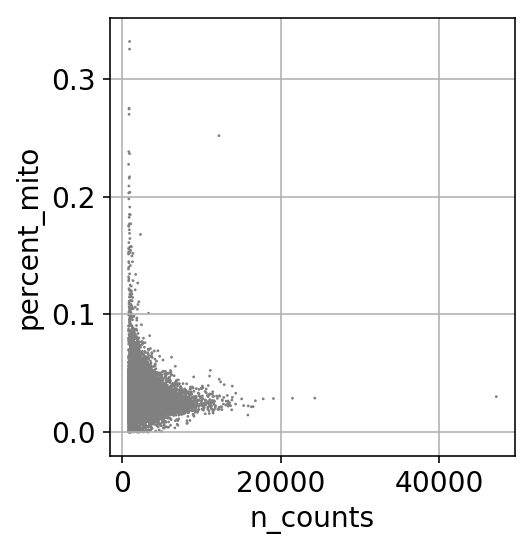

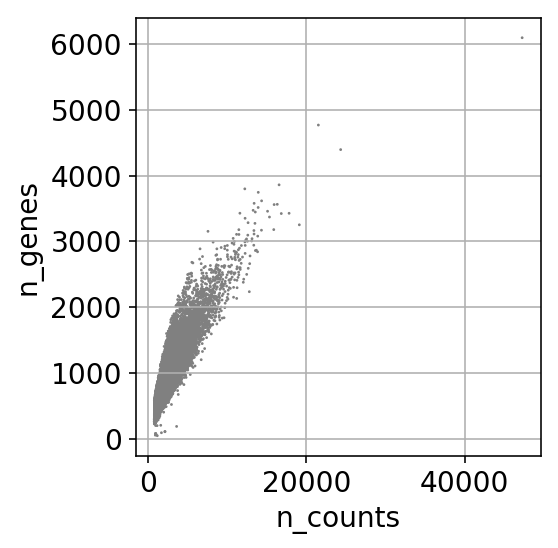

In [12]:
axs = sc.pl.scatter(PBMC_data, x='n_counts', y='percent_mito')
axs = sc.pl.scatter(PBMC_data, x='n_counts', y='n_genes')

In [6]:
sc.pp.filter_genes(PBMC_data, min_counts=1)  # only consider genes with more than 1 count
sc.pp.normalize_per_cell(PBMC_data)          # normalize with total UMI count per cell

In [7]:
sc.write('PBMC_nor', PBMC_data)

### Select HVGs

In [12]:
%%time
filter_result_PBMC = sc.pp.filter_genes_dispersion(PBMC_data.X, flavor='cell_ranger', n_top_genes=1000, log=False)
sc.logging.print_memory_usage()

Memory usage: current 3.45 GB, difference +3.45 GB
CPU times: user 1.62 s, sys: 1.14 s, total: 2.76 s
Wall time: 2.85 s


/home/USSR/xw251/anaconda2/envs/mypython3/lib/python3.6/site-packages/matplotlib/scale.py:103: RuntimeWarning: divide by zero encountered in log
  return np.divide(np.log(a, out=a), np.log(self.base), out=a)


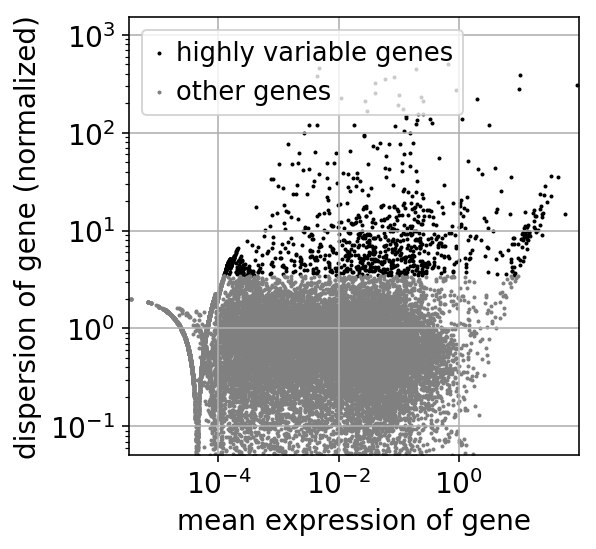

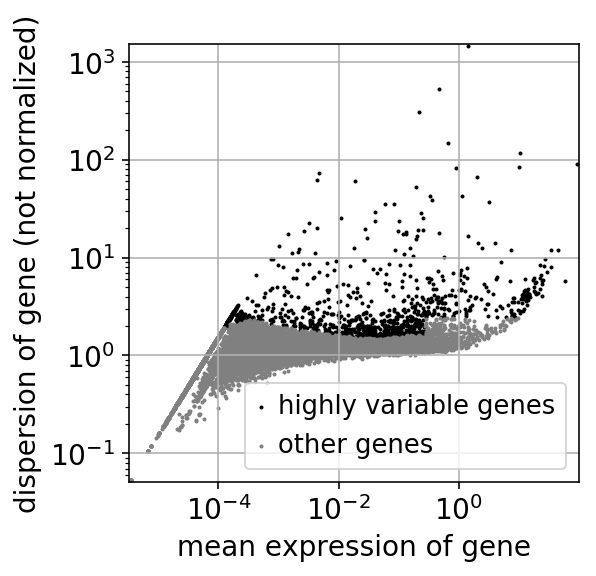

In [16]:
sc.pl.filter_genes_dispersion(filter_result_PBMC, log=True)

In [13]:
PBMC_data = PBMC_data[:, filter_result_PBMC.gene_subset] 

In [14]:
%%time
sc.pp.log1p(PBMC_data)
PBMC_data = sc.pp.regress_out(PBMC_data, ['n_counts', 'percent_mito'], copy=True)
sc.pp.scale(PBMC_data)
sc.logging.print_memory_usage()


Memory usage: current 0.48 GB, difference -2.97 GB
CPU times: user 8min 13s, sys: 4.45 s, total: 8min 18s
Wall time: 8min 17s


### PCA

In [19]:
%%time
sc.tl.pca(PBMC_data, n_comps=50)
sc.logging.print_memory_usage()

Memory usage: current 0.37 GB, difference +0.06 GB
CPU times: user 39.7 s, sys: 1.48 s, total: 41.2 s
Wall time: 7.18 s


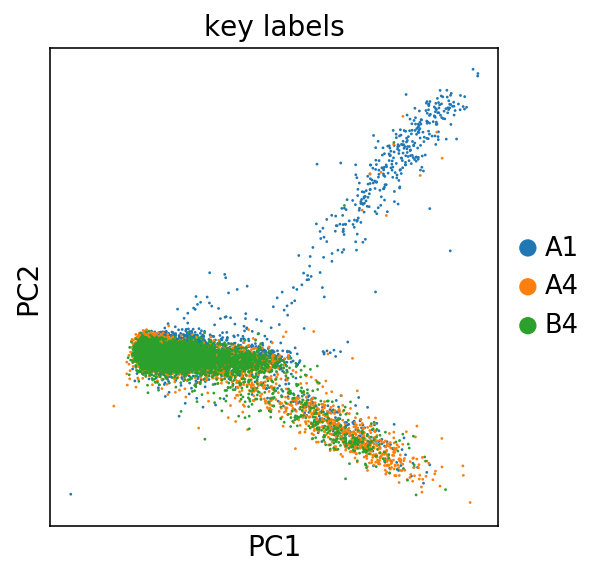

In [20]:
sc.pl.pca_scatter(PBMC_data, components= '1,2', color=['key_labels'])

### TSNE

In [15]:
%%time
sc.tl.tsne(PBMC_data,n_jobs=40, random_state=7, n_pcs=30)
sc.logging.print_memory_usage()

Memory usage: current 0.54 GB, difference +0.06 GB
CPU times: user 14min 44s, sys: 29min 56s, total: 44min 40s
Wall time: 1min 17s


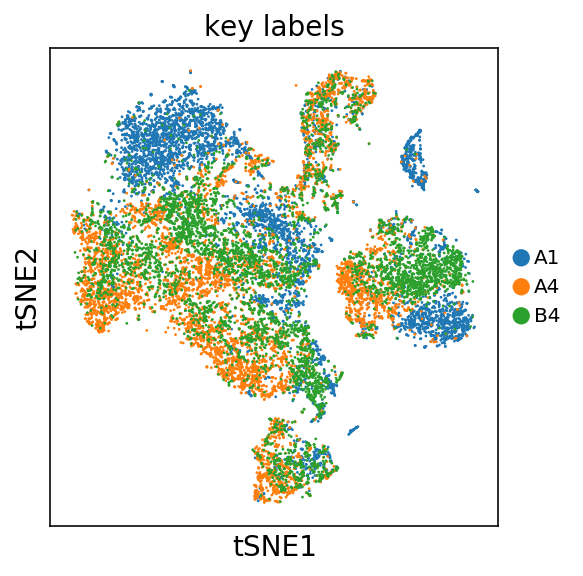

In [23]:
axs = sc.pl.tsne(PBMC_data, color='key_labels', legend_loc='right margin', legend_fontsize=10)

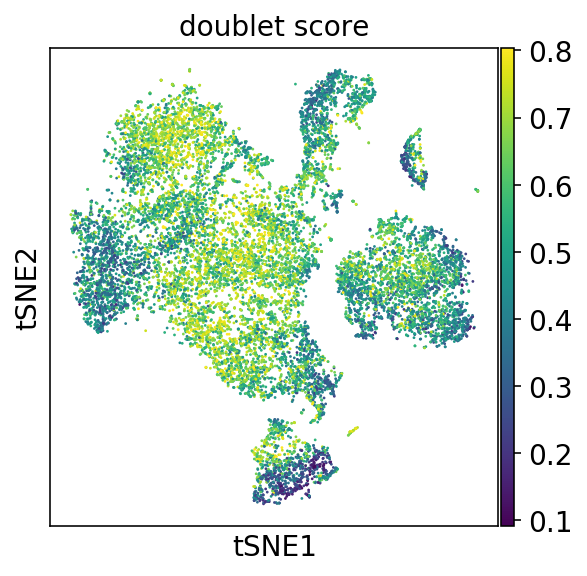

In [25]:
axs = sc.pl.tsne(PBMC_data, color='doublet_score', legend_loc='right margin', legend_fontsize=10)

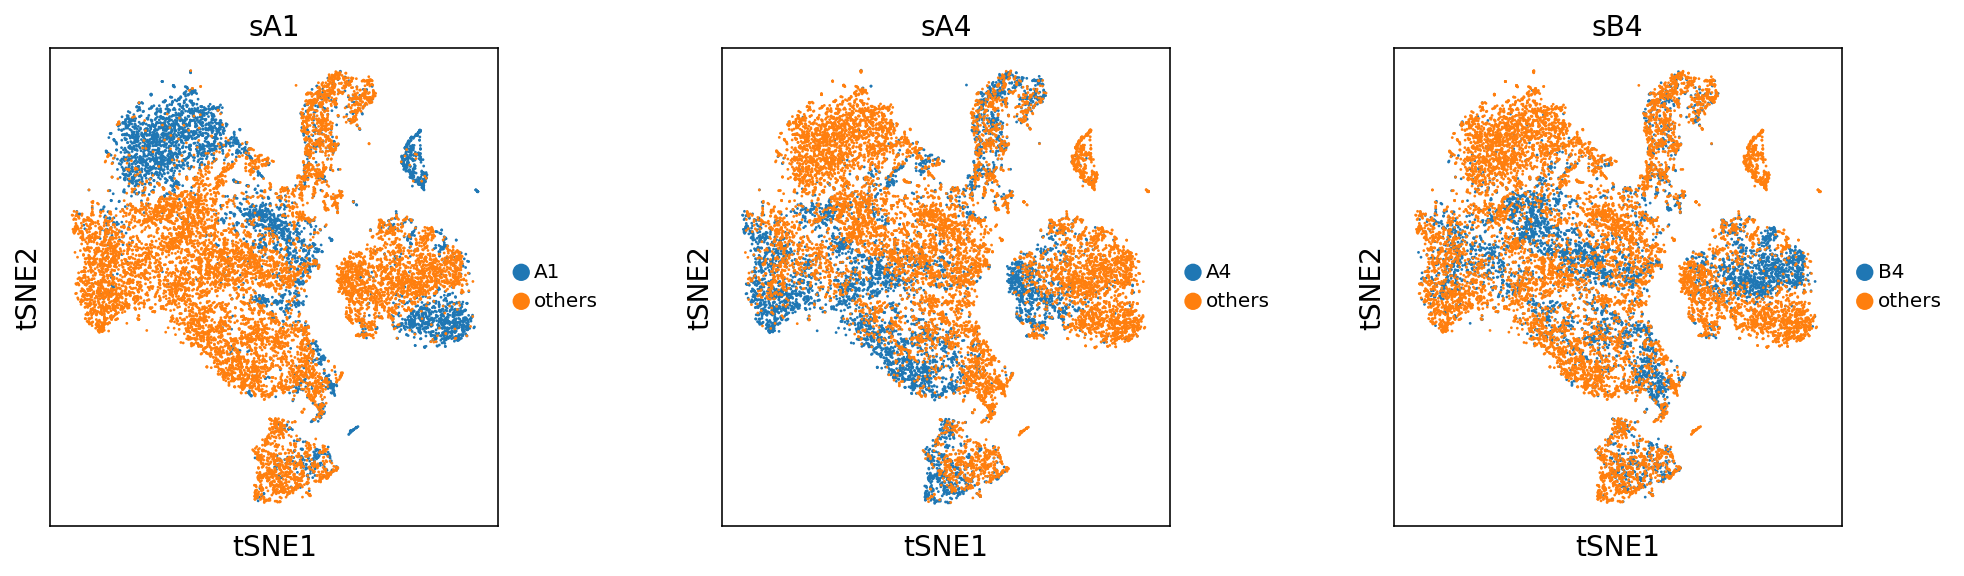

In [27]:
axs = sc.pl.tsne(PBMC_data, color=['sA1', 'sA4', 'sB4'], legend_loc='right margin', legend_fontsize=10)

### Louvain clustering

In [52]:
%%time
sc.tl.louvain(PBMC_data, resolution=1.0, n_jobs=40)
sc.logging.print_memory_usage()

Memory usage: current 2.58 GB, difference -1.90 GB
CPU times: user 14.6 s, sys: 44 ms, total: 14.7 s
Wall time: 14.7 s


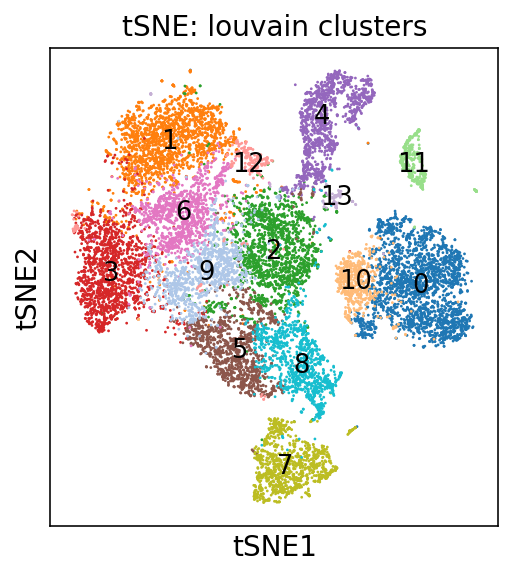

In [6]:
ax = sc.pl.tsne(PBMC_data, color=['louvain_groups'], legend_loc='on data', title='tSNE: louvain clusters')

In [55]:
sc.write('./write/PBMC_noBC', PBMC_data)